# Classifying text into categories

## Requirements 
- Python 3.6.4
- mitie==0.2.0
- numpy==1.13.3
- scikit-learn==0.19.1
- matplotlib==2.1.2

- place total_word_feature_extractor.dat file in the same directory as this ipynb file

## 1. Class for holding training data information


In [4]:
from sklearn.model_selection import train_test_split

class LabelledData:
    """
    This class holds the text and category data 
    as well as tokens and features data
    """
    
    def __init__(self, input_file='LabelledData.txt'):
        """
        Args:
            input_file(string): input text file path name containing
                                text and category separated by (without square brackets) [ ,,, ] 
        """
        self.labelled_data=[]
        self.tokens = None
        self.features = None

        with open(input_file) as data_file:
            for line in data_file:
                txt, intent = line.strip().split(' ,,, ')
                temp_data_dict = {}
                temp_data_dict['txt'] = txt.strip()
                temp_data_dict['intent'] = intent.strip()
                self.labelled_data.append(temp_data_dict)

    def __iter__(self):
        for data_instance in self.labelled_data:
            yield data_instance
                
    def get_labels(self):
        return [instance['intent'] for instance in self.labelled_data]
    
    def get_text(self):
        return [instance['txt'] for instance in self.labelled_data]
    
    def get_train_labels(self):
        return [instance['intent'] for instance in self.train_data]
    
    def get__train_text(self):
        return [instance['txt'] for instance in self.train_data]
    
    def get_test_labels(self):
        return [instance['intent'] for instance in self.test_data]
    
    def get__test_text(self):
        return [instance['txt'] for instance in self.test_data]
    
    def perform_train_test_split(self, test_size=0.3):
        """
        Args:
            test_size (float): test split fraction size
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( self.get_text(), self.get_labels(), test_size=test_size, random_state=42)
        self.train_data = []
        for text, label in zip(self.X_train, self.y_train):
            temp_data_dict = {}
            temp_data_dict['txt'] = text
            temp_data_dict['intent'] = label
            self.train_data.append(temp_data_dict)
            
        self.test_data = []
        for text, label in zip(self.X_test, self.y_test):
            temp_data_dict = {}
            temp_data_dict['txt'] = text
            temp_data_dict['intent'] = label
            self.test_data.append(temp_data_dict)
        
        
        
        
    
labelled_data = LabelledData()
#labelled_data.get_labels()

labelled_data.perform_train_test_split()


## 2. Tokenizer to split text into tokens

In [5]:

import mitie

class Tokenizer:
    """
    for creating tokens from text
    'hello wold this is me.' ==> ['hello', 'world', 'this', 'is', 'me', '.']
    """
    
    
    def __init__(self):
        pass
    
    def process_data(self, labelled_data):
        """
        Args:
            labelled_data (LabelledData): LabelledData obeject 
                                          created using the training file
        """
        for instance in labelled_data:
            instance['tokens'] =  self.tokenize_text(instance['txt'])
            
    def tokenize_text(self, text):
        """
        Args:
            text (string): text to be tokenized
        """
        tokens = [token.decode('utf-8') for token,_ in mitie.tokenize_with_offsets(text)]
        return tokens
    

tokenizer = Tokenizer()
tokenizer.process_data(labelled_data.train_data)


## 3. Feature extractor class using mitie total_word_feature_extractor

In [6]:
import numpy as np
import mitie
class Featurizer:
    """
    for extracting lexical features from tokens
    requires total_word_feature_extractor.dat file
    """
    
    def __init__(self, mitie_file='total_word_feature_extractor.data'):
        """
        Args:
            mitie_file (string): total_word_feature_extractor.data absolute file path name
        """
        self.feature_extractor = mitie.total_word_feature_extractor(mitie_file)
        
    def process_data(self, labelled_data):
        """
        Args:
            labelled_data (LabelledData): LabelledData object after tokenization is done
        """
        for instance in labelled_data:
            instance['features'] =  self.get_features(instance['tokens'])
            
    def get_features(self, tokens):
        """
        Args:
            tokens(string[]): array of tokens 
        
        """
        vec = np.zeros(self.feature_extractor.num_dimensions)
        for token in tokens:
            vec += self.feature_extractor.get_feature_vector(token)
        return vec / len(tokens) if tokens else vec
        
featurizer = Featurizer('total_word_feature_extractor.dat')
featurizer.process_data(labelled_data.train_data)


## 4. Category classifier 
uses sklearn svc and gridsearch to tune hyper parameters C and select appropriate kernal
- this will take a while - wait until it finishes
- change verbose param of GridSearchCV to get a better view of trianing steps

In [7]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import cloudpickle

class CategoryClassifier:
    """
    classifier class for text categorization
    """
    
    
    def __init__(self, labelled_data=None):
        """
        Args:
            labelled_data (LabelledData): LabelledData object 
                                          after tokenization and featurization
            clf_file(string): pickled classifer file path name
        """
        self.labelled_data = labelled_data
        self.label_encoder = LabelEncoder()
        
    def _encode_labels(self, labels):
        """
        encode the labels into numbers
        """
        return self.label_encoder.fit_transform(labels)
    
    def train(self):
        y = self._encode_labels(labelled_data.get_train_labels())
        X = np.stack([instance["features"] for instance in self.labelled_data])
        C =  [1, 2, 5, 10, 20, 100] 
        kernel = "linear"
        tuned_parameters = [{"C": C, "kernel": ["linear", "rbf"]}]

        self.clf = GridSearchCV(SVC(C=1, probability=True, class_weight='balanced'),
                                param_grid=tuned_parameters, n_jobs=4,
                                cv=5, scoring='f1_weighted', verbose=1)
        self.clf.fit(X, y)
        
    def predict(self, X):
        """predict categories using the given features
        
        """
        pred_result = self.predict_probability(X)
        sorted_indices = np.fliplr(np.argsort(pred_result, axis=1))
        return sorted_indices, pred_result[:, sorted_indices]
    
    def predict_probability(self, X):
        
        return self.clf.predict_proba(X)
    
    def save_classifier(self):
        cl_file_name = 'category_classifer.pkl'
        with open(cl_file_name, 'wb') as clf_file:
            cloudpickle.dump(self, clf_file)
    
    @classmethod
    def load_classifier(self, clf_file_name):
        with open(clf_file_name, 'rb') as clf_file:
            return cloudpickle.load(clf_file)
    
        

clf = CategoryClassifier(labelled_data.train_data)
clf.train()



    


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   17.2s finished


##  5. Save and resurrect the classifier 
- save_classifier: to serialize the classifier to the disk 
- load_classifier: load classifier from the pickled file

In [8]:
clf.save_classifier()
new_clf = CategoryClassifier.load_classifier('category_classifer.pkl')

## 6. Validate the final model

## Use the test split data to validate the final model and plot confusion matrix

Confusion matrix, without normalization
[[ 30   2   0   0   0]
 [  1  63  10   4   5]
 [  1   7 163   5   1]
 [  0   2   3  25   0]
 [  0   3   2   0 118]]


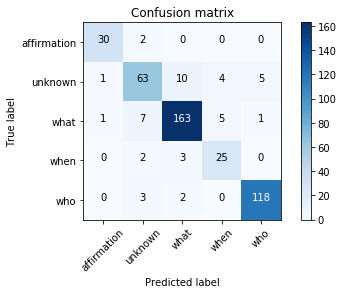

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
tokenizer = Tokenizer()
tokenizer.process_data(labelled_data.test_data)
featurizer.process_data(labelled_data.test_data)
X = np.stack([instance["features"] for instance in labelled_data.test_data])
Y = [instance['intent']  for instance in labelled_data.test_data]
Y_hat_lab, Y_hat_prob = clf.predict(X)   
Y_hat_lab = clf.label_encoder.inverse_transform([a[0] for a in Y_hat_lab])
cm = confusion_matrix(Y , Y_hat_lab)

##plot function taken from sklearn documentation - example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, clf.label_encoder.inverse_transform(new_clf.clf.classes_))

## 7. Use the trained classifier to predict labels for new text
change text variable value to the text you want to test

In [11]:
#text = 'What time does the train leave?' #Change me
text = 'What is artificial intelligence ?'
tokens = tokenizer.tokenize_text(text)
features = featurizer.get_features(tokens)
intent_ids, probabilities = clf.predict(features.reshape(1,-1))

headers = ['rank', 'category', 'confidence']
print('_'*35)
print(f'{headers[0]:<10}{headers[1]:<15}{headers[2]:<10}')
print('_'*35)
for rank, (intent_id, probability) in enumerate(zip(intent_ids.T, probabilities[0].T)):
    #print(formatting.format())
    print(f'{rank:<10}{clf.label_encoder.inverse_transform(intent_id)[0]:<15}{probability[0]:<10.2f}')

___________________________________
rank      category       confidence
___________________________________
0         what           0.91      
1         unknown        0.09      
2         when           0.00      
3         affirmation    0.00      
4         who            0.00      
